# Neural Network From Scratch

Simply implementing a Feed-Forward Neural Network From Scratch

In [1]:
# Load some libraries
import time
import operator
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from keras.datasets import mnist # cheating a little, loading easy mnist dataset from keras library
from keras.utils import np_utils
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split
from scipy.special import expit # more robust sigmoid

Using TensorFlow backend.
/usr/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load and Preprocess our images

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize Pixel Values
X_train /= 255
X_test /= 255

# Convert array of ints (digit values) to one-hot encoded categorical
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# convert images from 28x28 to 1x784
X_train = np.reshape(X_train, (60000, 784))
X_test = np.reshape(X_test, (10000, 784))

# get validation set - essentially split test in half
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

print("Input:", X_train.shape[1])
print("Output:", y_train.shape[1])

Input: 784
Output: 10


In [3]:
X_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [4]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

## Define Useful Utilities

In [5]:
# Define some functions

# Activation Function
def activation(x, derivative=False):
    return relu(x, derivative=derivative)

def tanh(x, derivative=False):
    return 1 - np.power(x, 2) if derivative else np.tanh(x)

def sigmoid(x, derivative=False):
    return x * (1 - x) if derivative else expit(x)

def relu(x, derivative=False):
    return (x>0).astype(x.dtype) if derivative else np.maximum(x, 0, x)

def softmax(x):
    return np.apply_along_axis(_softmax, 1, x)

def _softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)    

def calculate_loss(model):
    # Computes loss for train and validation sets
    W1, b1, W2, b2= model['W1'], model['b1'], model['W2'], model['b2']
    
    # Train Forward propagation train to calculate our predictions 
    l1 = activation(X_train.dot(W1) + b1) # Input -> Hidden 1 || activation(x.t * W + bias) 
    output_train = softmax(l1.dot(W2) + b2) # Hidden 1 -> Output || Softmax Probabilites
    
    # Validation Forward propagation train to calculate our predictions 
    l1 = activation(X_val.dot(W1) + b1) # Input -> Hidden 1 || activation(x.t * W + bias) 
    output_val = softmax(l1.dot(W2) + b2) # Hidden 1 -> Output || Softmax Probabilites
    
    # Calculating the loss
    return log_loss(y_train, output_train), log_loss(y_val, output_val)

def get_mini_batches(X, y, batch_size):
    random_idxs = np.random.choice(len(y), len(y), replace=False)
    X_shuffled = X[random_idxs,:]
    y_shuffled = y[random_idxs]
    mini_batches = [(X_shuffled[i:i+batch_size,:], y_shuffled[i:i+batch_size]) for
                   i in range(0, len(y), batch_size)]
    return mini_batches

def drop_connect_mask(prob, dimensions):
    mask_vector = np.random.binomial(1, prob, np.prod(dimensions))
    return mask_vector.reshape(dimensions)

## Initialize Params and Network Structure

In [6]:
# Define some parameters

# Layer Parameters
num_examples = X_train.shape[0] # training set size (60000)
nn_input_dim = X_train.shape[1] # input layer dimensionality (784)
nn_hdim_1 = 50
nn_output_dim = y_train.shape[1] # output layer dimensionality (10)

# Gradient descent parameters
epochs = 2000 # How many times to forward and back propigate the network
learning_rate = .001 # learning rate for gradient descent
decay = learning_rate / epochs # Default recommended by this blog post (https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
reg_lambda = 0 # regularization strength
drop_connect_prob = .3 # Probability to drop weight for DropConnect
batch_size = 128 # size of batches for minibatch gradient descent
print_loss = 20  # prints loss (and checks for early stopping) in some number of epochs
stop_threshold = 4  # threshold for early stopping using generalization error

# Constants for Adam Optimization (values are paper recommended values)
beta1 = 0.9
beta2 = 0.999
eps = 1E-8

In [7]:
# Input -> Hidden 1
W1 = np.random.randn(nn_input_dim, nn_hdim_1).astype(np.float32)
mW1 = np.zeros_like(W1)  # first-moment vector Adam Optimziation for W1
vW1 = np.zeros_like(W1)  # second-moment vector Adam Optimization for W1
b1 = np.zeros((1, nn_hdim_1))

# Hidden 1 -> Output
W2 = np.random.randn(nn_hdim_1, nn_output_dim).astype(np.float32)
mW2 = np.zeros_like(W2)  # first-moment vector Adam Optimziation for W2
vW2 = np.zeros_like(W2)  # second-moment vector Adam Optimization for W2
b2 = np.zeros((1, nn_output_dim))

W1.shape # for each node in input, there is a weight that corresponds with a node in hidden layer 1 (23520 total weights)

(784, 50)

## Train Our Network

In [8]:
# Now our Network

model = {}
losses_log = []  #simple list to plot loss over time
opt_loss_val = 10000  # init optimum validation set loss to track generalization loss for stopping threshold
start_time = time.time()  # track how long gradient descent takes

# Gradient descent...
# start at 1 instead of 0 for Adam Optimizer - avoids divide by 0
for i in range(1, epochs+1):
    
    mini_batches = get_mini_batches(X_train, y_train, batch_size)
    for mb in mini_batches:
        X_mb = mb[0]
        y_mb = mb[1]
 
        # Forward propagation
        # Get DropConnect Mask (0's and 1's in shape of W1)
        # This randomly turns weights on and off with some probability
        # http://www.matthewzeiler.com/wp-content/uploads/2017/07/icml2013.pdf
        dc_mask = drop_connect_mask(drop_connect_prob, W1.shape)
        dcW1 = W1 * dc_mask # Apply DropConnect Mask to W1
        l1 = activation(X_mb.dot(dcW1) + b1) # Input -> Hidden 1 || activation(x.t * W + bias)
        output = softmax(l1.dot(W2) + b2) # Hidden 1 -> Output || Softmax Probabilites

        # Backpropagation   
        output_error = output - y_mb # technically, you'd need a derived softmax activation, but that equals 1, so we don't add it
        l1_error = output_error.dot(W2.T) * activation(l1, True)
    
        dW2 = np.dot(l1.T, output_error)
        db2 = np.average(output_error, axis=0)
        dW1 = np.dot(X_mb.T, l1_error)
        db1 = np.average(l1_error, axis=0)
    
        # Apply DropConnect Mask to gradients, so only "activated" weights are updated
        dW1 = dW1 * dc_mask
    
        # add regularization terms to weights
        dW2 += reg_lambda * W2 
        dW1 += reg_lambda * W1
        
        # Update weights by using Adam Optimization (as opposed to simply learning_rate * gradient)
        # https://arxiv.org/pdf/1412.6980.pdf
        # http://cs231n.github.io/neural-networks-3/ (See Section: Per-parameter adaptive learning rate methods)
        # Update W1
        mW1 = beta1*mW1 + (1-beta1)*dW1
        mtW1 = mW1 / (1-beta1**i)
        vW1 = beta2*vW1 + (1-beta2)*(dW1**2)
        vtW1 = vW1 / (1-beta2**i)
        W1 += -learning_rate * mtW1 / (np.sqrt(vtW1) + eps)
        
        # Update W2
        mW2 = beta1*mW2 + (1-beta1)*dW2
        mtW2 = mW2 / (1-beta1**i)
        vW2 = beta2*vW2 + (1-beta2)*(dW2**2)
        vtW2 = vW2 / (1-beta2**i)
        W2 += -learning_rate * mtW2 / (np.sqrt(vtW2) + eps)

        # Update Biases
        b1 += -learning_rate * db1 
        b2 += -learning_rate * db2
    
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Update Learning Rate
    # Theoretically, learning rate decay is already guaranteed by Adam optimizer
    # Uncomment this line to use a time-based learning rate decay anyways
    #Learning_rate = Learning_rate * 1/(1 + decay * i)
    
    # Optionally print the loss. 
    # This is expensive because it uses the whole dataset, so we don't want to do it too often. 
    if i % print_loss == 0 or i == 1:
        loss_train, loss_val = calculate_loss(model)
        print("Loss after iteration %i -> Train: %f, Validation: %f" %(i, loss_train, loss_val))
        
        # Generalization Loss Early Stopping
        # This is intuitively "the percent of generalization we have lost"
        # Section 2.1: http://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf
        generalization_loss = 100 * (loss_val/opt_loss_val - 1)
        print("\t- Generalization Loss: %f" %(generalization_loss))
        
        losses_log.append([i,loss_train, loss_val, generalization_loss])
        
        # Check to see if stop early
        if generalization_loss > stop_threshold:
            print("Gradient Descent Stopped Early!")
            break
        else:
            # update optimal validation loss if better than current optimal
            if loss_val < opt_loss_val :
                opt_loss_val = loss_val

print("--- Time: %s seconds ---" % (time.time() - start_time))

Loss after iteration 1 -> Train: 11.928844, Validation: 11.704974
	- Generalization Loss: -99.882950
Loss after iteration 20 -> Train: 2.069785, Validation: 2.058670
	- Generalization Loss: -82.412011
Loss after iteration 40 -> Train: 0.905545, Validation: 0.910487
	- Generalization Loss: -55.773029
Loss after iteration 60 -> Train: 0.688249, Validation: 0.716971
	- Generalization Loss: -21.254140
Loss after iteration 80 -> Train: 0.601127, Validation: 0.636245
	- Generalization Loss: -11.259285
Loss after iteration 100 -> Train: 0.519188, Validation: 0.568494
	- Generalization Loss: -10.648600
Loss after iteration 120 -> Train: 0.458394, Validation: 0.512845
	- Generalization Loss: -9.788760
Loss after iteration 140 -> Train: 0.402886, Validation: 0.451076
	- Generalization Loss: -12.044551
Loss after iteration 160 -> Train: 0.365716, Validation: 0.413095
	- Generalization Loss: -8.419913
Loss after iteration 180 -> Train: 0.332083, Validation: 0.380740
	- Generalization Loss: -7.8323

## Visualize Our Results

In [9]:
# Grab our losses

iters = []
losses_train = []
losses_val = []
gen_loss = []
for ll in losses_log:
    iters.append(ll[0])
    losses_train.append(ll[1])
    losses_val.append(ll[2])
    gen_loss.append(ll[3])

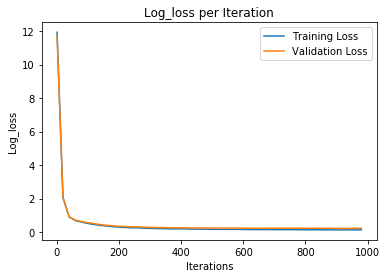

In [10]:
# Log_loss over time

# This gives us a very smooth log_loss plot, which is unusual. Keep that in mind.

plt.plot(iters, losses_train, label='Training Loss')
plt.plot(iters, losses_val, label='Validation Loss')
plt.ylabel('Log_loss')
plt.xlabel('Iterations')
plt.legend(loc=1)
plt.title('Log_loss per Iteration')
plt.show()

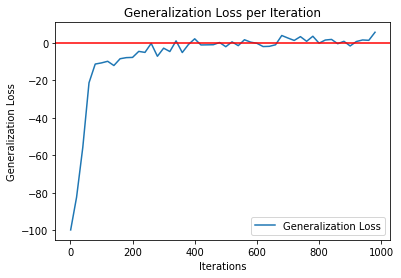

In [11]:
# Generalization Loss Over Time

plt.plot(iters, gen_loss, label='Generalization Loss')
plt.ylabel('Generalization Loss')
plt.xlabel('Iterations')
plt.legend(loc=4)
plt.title('Generalization Loss per Iteration')
plt.axhline(0, color='red')
plt.show()

In [12]:
# let's see how we did

# Forward Propigate to get outputs on train data
l1_train = activation(X_train.dot(W1) + b1) # Input -> Hidden 1 || activation(x * W + bias)
output_train = softmax(l1_train.dot(W2) + b2)

# Forward Propigate to get outputs on test data
l1_test = activation(X_test.dot(W1) + b1) # Input -> Hidden 1 || activation(x * W + bias)
output_test = softmax(l1_test.dot(W2) + b2) # Hidden 1 -> Output || Softmax Probabilites

correct_train = 0
for i in range(0, output_train.shape[0]):
    if np.argmax(output_train[i]) == np.argmax(y_train[i]):
        correct_train += 1

correct_test = 0
for i in range(0, output_test.shape[0]):
    if np.argmax(output_test[i]) == np.argmax(y_test[i]):
        correct_test += 1

train_accuracy = correct_train / y_train.shape[0]
test_accuracy = correct_test / y_test.shape[0]

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.9760166666666666
Test Accuracy: 0.9716
